In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Calculate $p_{\mathrm{bound}}$

In [6]:
def get_pactive(c, KA, KI, eAI):
    z = np.zeros(4)
    z[0] = 1
    z[1] = c / KA
    z[2] = np.exp(-eAI)
    z[3] = z[2] * c / KI
    return (z[0] + z[1]) / np.sum(z)


def simrep_pbound_with_inducer(p_seq, r_seq, n_NS, n_p, n_r,
                               p_emat, r_emat, ep_wt, era_wt, eri_wt,
                               c, KA, KI, eAI):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_ra = tregs.simulate.get_weight(r_seq, r_emat, e_wt=era_wt)
    w_ri = tregs.simulate.get_weight(r_seq, r_emat, e_wt=eri_wt)
    pactive = get_pactive(c, KA, KI, eAI)

    z = np.zeros(4)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = pactive * n_r / n_NS * w_ra
    z[3] = (1 - pactive) * n_r / n_NS * w_ri

    return z[1] / np.sum(z)

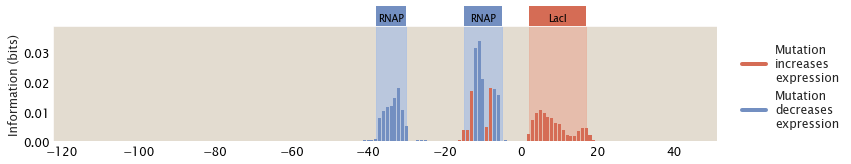

In [7]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
era_wt = -15
eri_wt = -1
c = 10**(-6)
KA = 139 * 10**(-6)
KI = 0.53 * 10**(-6)
eAI = 4.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig3/simrep.png')

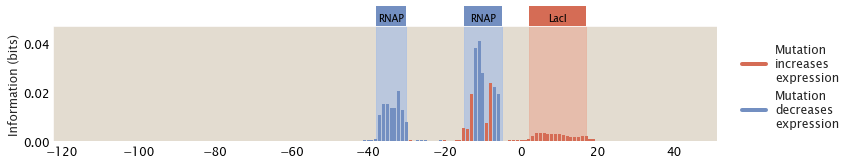

In [8]:
n_NS = len(genome)
n_p = 4600
n_r1 = 10
ep_wt = -5
era_wt = -15
eri_wt = -1
c = 10**(-2)
KA = 139 * 10**(-6)
KI = 0.53 * 10**(-6)
eAI = 4.5

df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False)

In [14]:
signal = []
inducer_conc = []
for i in np.arange(-6, -1, 0.1):
    c = 10**i
    inducer_conc.append(c)

    df = tregs.simulate.sim(promoter, simrep_pbound_with_inducer, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, era_wt, eri_wt, c, KA, KI, eAI])

    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    upper_bound = np.mean(mu_data)
    nbins = 2

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
    signal.append(np.mean(footprint[(2+115):(17+116)]))

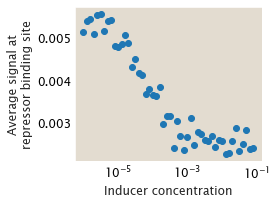

In [17]:
# plot signal vs inducer concentration
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(inducer_conc, signal)
ax.set_xscale('log')
ax.set_xlabel('Inducer concentration')
ax.set_ylabel('Average signal at\nrepressor binding site')
plt.tight_layout()